This Notebook combines the data used in http://localhost:8888/notebooks/20170126_TensorFlow_Matrix_Factorization_Recommender.ipynb, which used an implementation of Alternating Least Squares, with the algorithm used in http://localhost:8888/notebooks/20170221_VAE.ipynb, which uses a Variational Autoencoder instead.

Also see this article file:///home/fred/Documents/articles/recommender_systems/hybrid_collab_filt_w_AEs_1603.00806v3.pdf which explains a bit about the VAE method applied to sparse data (and incorporation of side information to help w/ the cold start problem).

From [Matrix Factorization with Tensorflow](http://katbailey.github.io/post/matrix-factorization-with-tensorflow/):
> I just started reading this paper on [Probabilistic Matrix Factorization](http://papers.nips.cc/paper/3208-probabilistic-matrix-factorization.pdf), which says in its introduction:
> > Since **most real-world datasets are sparse**, most entries in R will be missing. In those cases, the sum-squared **distance is computed only for the observed entries** of the target matrix R. As shown by (…), this seemingly minor modification results in a **difficult non-convex optimization problem** which cannot be solved using standard SVD implementations.


In [1]:
# https://github.com/ipython/ipykernel/issues/111
# Create logger
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
import sys # create STDERR handler
handler = logging.StreamHandler(sys.stderr)
# ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)-15s : %(levelname)s : %(message)s') # - %(name)s %(clientip)s %(user)-8s
handler.setFormatter(formatter) # create formatter and add it to the handler
logger.handlers = [handler] # set STDERR handler as the only handler 

In [2]:
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from importlib import reload
np.random.seed(0)
tf.set_random_seed(0)

In [3]:
from tf_autoencoder import sparse_pivot
from tf_autoencoder import vae
from tf_autoencoder import dataset
from tf_autoencoder import train

2017-03-06 08:04:14,270 : INFO : tf_autoencoder imported


In [4]:
import os
import pandas as pd

# specify which dataset to use
which = '10m' # 100k, 1m or 10m

datapath = os.path.join(os.getcwd(), 'data', 'movielens-{}'.format(which), ('u.data' if which=='100k' else 'ratings.dat'))
df = pd.read_csv(datapath, sep=('\t' if which=='100k' else '::'), header=None, names=['user', 'item', 'rating', 'timestamp'])
print('{}\n{}\n{}'.format(df.dtypes, df.columns, df.shape))

/home/fred/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


user           int64
item           int64
rating       float64
timestamp      int64
dtype: object
Index(['user', 'item', 'rating', 'timestamp'], dtype='object')
(10000054, 4)


In [39]:
reload(sparse_pivot)

# including both training and test data in the same matrix so that all users and
# items are accounted for in the resulting DataSet
n_training = int(8e6)
n_validation = int(2e6) #+ 54 #+ 209
n_test = 0
trmat, vamat, temat = sparse_pivot.f(df,#[0 : n_training + n_validation + n_test],
                                     'user', 'item', 'rating',
                                     n_training, n_validation, n_test,
                                     shuffle=True, # shuffle should be true when using 'datapoint' b/c of potential user-based ordering in the files (e.g. in the 10m file)
                                     split_basis='index')  # 'index' => disjoint'ify users; 'datapoint' => split users

# scale down to [0,1], though note that 0 indicates missing value in csr_matrix, this is what was causing
# the cost to go to NaN at times, self.x_reconstr_mean would end up with a value of 1.0 which would cause
# tf.log(1e-10 + 1 - self.x_reconstr_mean) to be -inf
scale = np.max(df['rating'])  # e.g. 5
trmat = trmat / scale
vamat = vamat / scale
temat = temat / scale
min_rating = np.min(df['rating']) / scale
print('scale={}, min_rating={}'.format(scale, min_rating))

# number of *unique* users and items
n_users = trmat.shape[0]
n_items = trmat.shape[1] # scipy.sparse.csr_matrix
n_densetot = n_users * n_items
pct_nonzero = n_training * 100 / n_densetot
print('trshape={}; vashape={}; n_nonzero=[{}, {}, {}]; pct_nonzero={:.3f}%'.format(trmat.shape,
                                                                     vamat.shape,
                                                                     len(trmat.nonzero()[0]),
                                                                     len(vamat.nonzero()[0]),
                                                                     len(temat.nonzero()[0]),
                                                                     pct_nonzero))
print(df[0:4])
# print(np.where(np.logical_and(trmat>=0.05, trmat<=0.15))) # really, really slow
x = trmat[2]
print(x.shape)
x = x[x != 0.0]
print(x.shape)
print(x) # see the 0.7s and 0.9s! (only when using 10m dataset though)
x = vamat[2]#34879] # 34879/80
x = x[x != 0.0]
print(x.shape)
print(x)

scale=5.0, min_rating=0.1
trshape=(55902, 10677); vashape=(13975, 10677); n_nonzero=[8013020, 1986858, 0]; pct_nonzero=1.340%
   user  item  rating  timestamp
0     1   122     5.0  838985046
1     1   185     5.0  838983525
2     1   231     5.0  838983392
3     1   292     5.0  838983421
(1, 10677)
(1, 38)
[[ 1.   0.2  0.4  0.6  0.8  0.8  0.8  0.6  0.4  0.6  0.6  0.4  0.6  0.6
   0.6  0.8  0.2  1.   0.8  0.6  0.8  0.2  0.6  0.2  0.4  1.   0.8  1.   0.6
   0.2  1.   0.2  0.4  0.8  0.6  1.   0.6  0.8]]
(1, 23)
[[ 1.   1.   0.8  1.   0.6  1.   0.4  0.4  0.8  0.6  1.   1.   0.4  0.2
   0.8  0.2  0.4  1.   0.2  0.6  0.2  1.   0.8]]


[588928817, 403782, 930593, 2594482, 2774733, 1233247]
[   76183.   308732.    95050.   634878.   295715.  1889599.   704883.
  2306663.   468070.  1233247.]


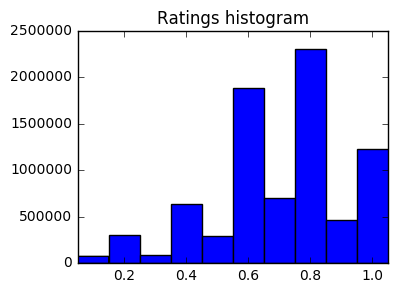

In [40]:
# we'd like to sample evenly from the 5 recommendation levels, which is basically impossible
# when sampling individual users (because on average they're all individually biased), so maybe
# more weight needs to be given in the loss function to under-represented ratings

# use numpy to compute the values in the histogram
nzcounts = [np.sum(np.diff((trmat > (i+1) / 5 - 0.01).indptr)) for i in range(5)]
cumcounts = [n_densetot] + nzcounts + [0]
counts = [i0 - i1 for i0, i1 in zip(cumcounts, cumcounts[1:])]
print(counts)

# or just use matplotlib to get histogram counts
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
counts1 = ax.hist(trmat.data, bins=[((i+1) / 10 - 0.05) for i in range(10)] + [100000])
print(counts1[0])
ax.set_title("Ratings histogram")
ax.set_xlim(0.05, 1.05);

### TODO: predict 0/1 unrated/rated first, then given 'rated' predict 'rating' ...
... because some users may not give ratings (i.e. their ratings are implicit in their having marked something in the first place) but our loss function only considers rated items so it may predict constants for these users while we actually want to predict what to read vs. not to read first and only how high the user will rate it second

"we can't just treat the missing data as unknowns, instead we have to treat a user not listening to an artist as being a signal that the user might not like that artist." [http://www.benfrederickson.com/matrix-factorization/]

### TODO: after encoding, run k-means clustering to deterime representative values for each of ...
... the clusters.  encoding seems to separate points in space but it doesn't do so in a way s.t. you end up with 1-hot vectors.  k-means clustering is a way to transform or rotate axes perhaps that converts back to 1-hot and from there representatives can be assigned to each bit of the 1-hot.  in other words a natural language "meaning" can be given to each cluster

### TODO: haven't yet incoporated side information (see hybrid_collab_filt_w_AEs_1603.00806v3.pdf)

In [48]:
reload(vae)
reload(dataset)
reload(train)

trdata = dataset.DataSet(trmat)
vadata = dataset.DataSet(vamat)

# TODO: the fact that using far fewer units in the hidden layers (e.g. 4 vs. 40) doesn't affect
# the RMSE could mean that the weights are all converging to the same values (i.e. lots of redundancy
# in a larger network)

# the original MNIST notebook uses 500/500/20 for these values
nh1 = 600 # int(n_items/10)  # 1/10 of n_input? as suggested here: https://hal.inria.fr/hal-01256422v1/document
nh2 = 400 # int(n_items/12)  # 1/12 of n_input? as suggested in same paper (except that this is their central layer!)
nz = 100  # 20? or was it 200? suggested by same paper?

netarch = {'n_input':n_items, # number of items (1m=3706, 100k=1682)
           'n_hidden_recog_1':nh1, # 1st layer encoder neurons
           'n_hidden_recog_2':nh2, # 2nd layer encoder neurons
           'n_z':nz,               # dimensionality of latent space
           'n_hidden_gener_1':nh2, # 1st layer decoder neurons
           'n_hidden_gener_2':nh1} # 2nd layer decoder neurons

# see comment below on why maximizing the reconstruction-to-input slope might be
# a good way to set this exponent parameter (0 is equivalent to not using rdist)
rdist_pow = 1
rdist = counts1[0]
rdist = rdist / sum(rdist) * len(rdist) # normalize mean to 1.0: [ 0.3095     0.5620625  1.35425    1.709625   1.0645625]
if rdist_pow != 1: print('rdist0 = {}'.format(rdist))
rdist = np.power(rdist, rdist_pow) # accentuate: [ 0.17218328  0.42138291  1.57597116  2.23537963  1.09839044]
rdist = rdist / sum(rdist) * len(rdist) # renormalize: [ 0.15643618  0.38284515  1.43184002  2.030942    0.99793666]
print('rdist = {}'.format(rdist))

untrained_vae = vae.VariationalAutoencoder(netarch,
                                           learning_rate=0.001,
                                           corruption_level=0.3,
                                           use_rmse=True,
                                           min_rating=min_rating,
                                           rmse_correction=100.0, # rloss should start out around 200 and shrink
                                           rdist=rdist)           # lloss should start small and grow

batch_size = 500 # int(min(100, n_users/50))
print('batch_size = {}'.format(batch_size)) # 400 iters: rmse/va=0.1364/0.1947 but dloss/rloss=0.37 (w/ 600, 400, 40)
trained_vae = train.train(untrained_vae, trdata, vadata, display_step=20, training_epochs=371, batch_size=batch_size)

rdist = [ 0.09507402  0.38528794  0.11861945  0.79230802  0.36904313  2.35816084
  0.87967208  2.87864376  0.58413682  1.53905394]


/home/fred/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
2017-03-06 17:13:08,247 : INFO : vabatch.shape = (500, 10677)
2017-03-06 17:13:08,247 : INFO : Training on 55902 data points


batch_size = 500


2017-03-06 17:14:57,715 : INFO : Epoch: 001 cost/va=411.3/410.4 (245.3 +160.8 +1.34; d=39%) rmse/va=0.2251/0.2322
2017-03-06 17:14:57,716 : INFO :           [0.291, 0.163, 0.131, 0.215, 0.352] avg=0.230 stdev=0.081
2017-03-06 17:16:46,168 : INFO : Epoch: 002 cost/va=403.8/409.2 (242.8 +159.2 +0.66; d=39%) rmse/va=0.2222/0.2315
2017-03-06 17:16:46,169 : INFO :           [0.290, 0.164, 0.132, 0.212, 0.345] avg=0.229 stdev=0.079
2017-03-06 17:18:34,454 : INFO : Epoch: 003 cost/va=397.7/404.2 (238.5 +156.1 +1.62; d=39%) rmse/va=0.2188/0.2270
2017-03-06 17:18:34,454 : INFO :           [0.286, 0.165, 0.133, 0.208, 0.337] avg=0.226 stdev=0.076
2017-03-06 17:20:22,895 : INFO : Epoch: 004 cost/va=391.7/401.5 (234.2 +153.1 +2.68; d=39%) rmse/va=0.2140/0.2235
2017-03-06 17:20:22,896 : INFO :           [0.284, 0.167, 0.135, 0.202, 0.326] avg=0.223 stdev=0.072
2017-03-06 17:22:11,097 : INFO : Epoch: 005 cost/va=385.2/400.9 (229.6 +150.0 +3.44; d=38%) rmse/va=0.2107/0.2278
2017-03-06 17:22:11,098 : 

Evaluation of unsupervised learning depends on end application:
> Word2vec training is an unsupervised task, there’s no good way to objectively evaluate the result. Evaluation depends on your end application. [https://rare-technologies.com/word2vec-tutorial/]

FWC - Is "end application" defined as "reconstruction" in this case?  Is an autoencoder really even unsupervised?

The stdev of RMSE across the 5 ratings is something else that could be added to the optimization function in order to optimize the rdist exponent in VariationalAutoencoder class.

Training: poly: 0.5694 x + 0.2767; uniqpoly: 0.6294 x + 0.2392
Validation: poly: 0.6351 x + 0.2264; uniqpoly: 0.6116 x + 0.2438


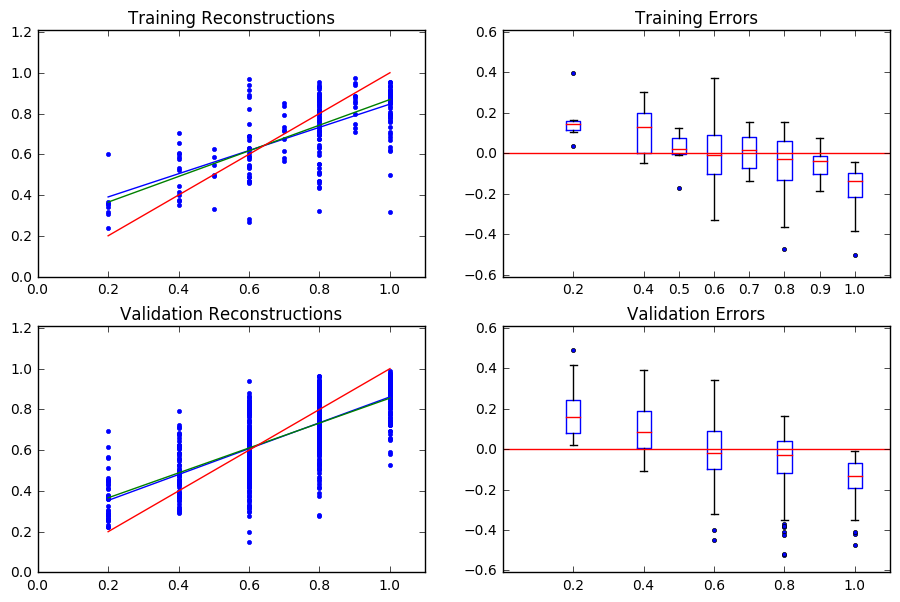

In [98]:
x_sample = trdata.next_batch(4).todense()
x_reconstr = trained_vae.reconstruct(x_sample)
va_sample = vadata.next_batch(4).todense()
va_reconstr = trained_vae.reconstruct(va_sample)

fig, ax = plt.subplots(2, 2, figsize=(11, 7))
for i in range(2):
    title = 'Training' if i == 0 else 'Validation'
    sample = x_sample if i == 0 else va_sample
    reconstr = x_reconstr if i == 0 else va_reconstr
    mask = np.greater(sample, 0.01)
    errors = reconstr - sample

    xs = np.asarray(sample[mask]).flatten()     # numpy has flatten,
    ys = np.asarray(reconstr[mask]).reshape(-1) # but tensorflow only has reshape(-1)
    ax[i][0].plot(xs, ys, 'b.')

    uniqxs = np.unique(xs)
    uniqys = [np.mean(ys[np.where(xs == x)]) for x in uniqxs]

    # the coefficient of this polynomial might be worth maximizing as it shows that the model is producing
    # a good separation between low and high ratings and not just fitting a constant to the mode of ratings
    poly = np.poly1d(np.polyfit(xs, ys, 1))
    uniqpoly = np.poly1d(np.polyfit(uniqxs, uniqys, 1)) # polynomial over the averages for each x value
    print('{}: poly: {}; uniqpoly: {}'.format(title, str(poly)[2:], str(uniqpoly)[2:]))

    ax[i][0].set_title('{} Reconstructions'.format(title))
    ax[i][0].plot(uniqxs, poly(uniqxs))
    ax[i][0].plot(uniqxs, uniqpoly(uniqxs))
    ax[i][0].plot(uniqxs, uniqxs)
    ax[i][0].set_xlim(0.0, 1.1); ax[i][0].set_ylim(0, 1.21)

    ax[i][1].set_title('{} Errors'.format(title))
    es = np.asarray(errors[mask]).reshape(-1)
    bp = ax[i][1].boxplot([es[xs == x] for x in uniqxs], sym='b.', positions=uniqxs, widths=0.04,
                          whiskerprops={'color':'#000000', 'linestyle':'-'})
    #ax[i][1].plot(xs, es, 'b.')
    ax[i][1].plot([0.0, 1.1], [0, 0], 'r')
    ax[i][1].set_xlim(0.0, 1.1); ax[i][1].set_ylim(-0.61, 0.61);

In [62]:
x_errors = x_reconstr - x_sample
x_mask = np.greater(x_sample, 0.01)
x_reduceddim = trained_vae.transform(x_sample) # note that this doesn't sample z's, it only returns z_mean
x_loss = trained_vae.loss(x_sample, x_reconstr)

print('x = {}'.format(x_sample[x_mask]))
print('reconstructed = {}'.format(x_reconstr[x_mask]))
print('errors = {}'.format(x_errors[x_mask]))
print('reduceddim = {}'.format(x_reduceddim))
print('loss = {}'.format(x_loss))
print('tf.rmse = {}'.format(trained_vae.rmse(x_sample, x_reconstr)))
print('np.rmse = {}'.format(np.sqrt(np.mean(np.square(x_errors[x_mask])))))

x = [[ 0.7  0.5  0.8  0.7  0.8  0.6  0.7  0.6  0.7  0.4  0.9  0.8  0.2  0.6
   0.8  0.7  0.6  1.   0.8  0.7  0.8  0.8  0.8  0.9  0.8  0.4  0.6  1.   0.6
   0.9  0.4  0.5  0.9  0.6  0.7  0.8  0.8  0.9  0.6  0.8  0.8  0.8  0.6
   0.8  0.6  0.6  0.8  0.8  0.3  0.9  0.7  0.4  0.9  0.7  0.8  0.8  0.8
   0.3  0.3  0.8  0.9  0.8  1.   0.4  0.8  0.9  1.   1.   0.7  0.4  0.7
   0.9  0.7  0.7  0.7  0.7  0.9  0.8  0.8  0.5  0.3  0.7  0.8  0.7  0.9
   0.9  0.6  0.7  0.7  1.   0.5  0.9  0.8  0.8  0.7  0.8  0.6  0.9  0.7
   0.8  0.7  0.7  0.7  0.6  0.7  0.6  0.9  0.9  0.8  0.8  0.9  0.5  0.6
   0.7  0.6  0.8  0.9  1.   0.8  0.8  0.6  0.9  1.   0.8  1.   1.   0.6
   0.7  1.   0.8  0.8  0.2  0.8  0.6  0.4  1.   1.   0.8  0.7  0.6  0.9
   0.7  0.8  0.2  0.8  0.7  0.8  0.6  0.8  0.9  0.8  0.9  0.8  0.6  0.7
   0.8  1.   0.9  0.6  0.8  0.8  0.8  0.8  0.9  0.8  0.6  0.8  0.7  0.8
   0.8  0.8  0.9  0.9  0.9  0.7  0.7  0.6  0.9  0.8  1.   0.8  0.7  0.9  1.
   0.9  0.8  0.8  0.8  0.9  0.8  0.8  0.7  0.7  0.8